In [1]:
import numpy as np
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering



stop_words = stopwords.words('spanish')

## Obtención de datos

In [2]:

def fetch_items(cat_id, offset):
    #Fetch the items with requests
    url = f'https://api.mercadolibre.com/sites/MCO/search?category={cat_id}&offset={offset}'
    request = requests.get(url)
    items = request.json()
    return items['results']

def save_items_to_json(cat_id):
    #Save the information over the offset iteration 
    all_items = []
    for offset in range(0, 951, 50):
        items = fetch_items(cat_id, offset)
        all_items.extend(items)
    
    with open('items.json', 'w') as file:
        json.dump(all_items, file)

cat_id = 'MCO1000'
save_items_to_json(cat_id)

with open('items.json', 'r') as file:
    items = json.load(file)

items_results = items.copy()
items_df = pd.json_normalize(items_results)

## Fuciones utilizadas para transformar los datos

In [3]:

def tokenize_title(title):
    #Split the string into words
    tokens = word_tokenize(title)
    return tokens

def remove_stopwords(tokens):
    #Set the stopwords that doesn't bring information
    stop_words = set(stopwords.words('spanish'))
    
    # Filter the tokens to delete the stopwords
    filtered_tokens = [token for token in tokens if token.lower() not in stop_words]
    
    return filtered_tokens


### Extracción y transformación de datos

In [4]:
filtered_items = (
    items_df[['id','title','category_id','price','seller.seller_reputation.power_seller_status','attributes']].copy())

brand = []

for i in filtered_items['attributes']:
    brand_value = next((attribute['value_name'] for attribute in i if attribute['id'] == 'BRAND'), '')
    brand.append(brand_value)
            
filtered_items['brand']  = brand

filtered_items = (
    filtered_items.dropna(subset=['brand', 'price', 'category_id']).drop('attributes', axis=1))

filtered_items = (
    filtered_items.assign(tokenized_title=filtered_items['title'].apply(tokenize_title)).drop('title', axis=1))

filtered_items['tokenized_title'] = (
    filtered_items['tokenized_title'].apply(remove_stopwords))

filtered_items['tokenized_title'] = (
    [' '.join(tokens) for tokens in filtered_items['tokenized_title']])

filtered_items['category'] = (
    filtered_items['category_id'].apply(lambda x: x[3:] if isinstance(x, str) else x))


### Proceso de analisis 

In [5]:

# Chose the attributes fon analysis
features = filtered_items[['tokenized_title', 'category']]

# Remove the null values from the selected columns
features = features.dropna()

# Concatenate the attributes into a single column
features['combined_features'] = features['tokenized_title'] + ' ' + features['category']

# Preprocess the information for model loading
vectorizer = TfidfVectorizer()
vectorized_features = vectorizer.fit_transform(features['combined_features'])


### Metodo del codo

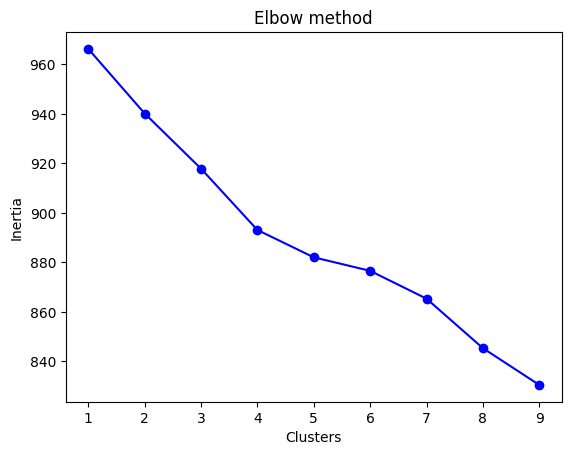

In [26]:

# Calculate the inertia for different values of k.
inertias = []
k_values = range(1, 10)  # Try different k values
for k in k_values:
    kmeans = KMeans(n_clusters=k,random_state=40, n_init='auto')
    kmeans.fit(vectorized_features)
    inertias.append(kmeans.inertia_)

# Plot the inertia curve
plt.plot(k_values, inertias, 'bo-')
plt.xlabel('Clusters')
plt.ylabel('Inertia')
plt.title('Elbow method')
plt.show()

### Metodo de la silueta

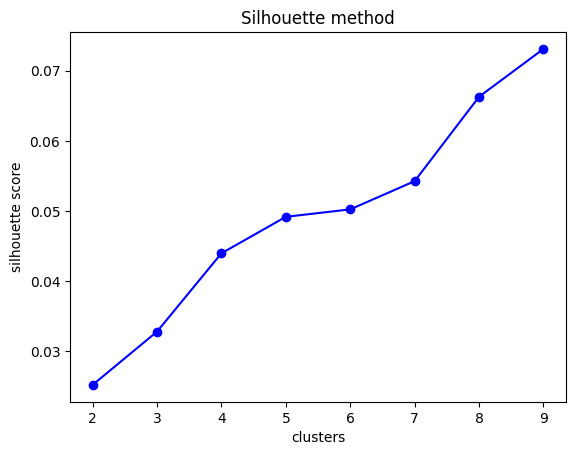

In [25]:
silhouette_scores = []

k_values = range(2, 10)  # Try different k values
for k in k_values:
    kmeans = KMeans(n_clusters=k,random_state=40 , n_init='auto')
    kmeans.fit(vectorized_features)
    labels = kmeans.labels_
    score = silhouette_score(vectorized_features, labels)
    silhouette_scores.append(score)

# Plot the curve of the average silhouette.
plt.plot(k_values, silhouette_scores, 'bo-')
plt.xlabel('clusters')
plt.ylabel('silhouette score')
plt.title('Silhouette method')
plt.show()

### Aplicación del modelo con el número de clusters calculado

#### Utilizando Kmeans.fit

In [8]:
# Apply the K-means clustering algorithm
k = 6  # Desired number of clusters
kmeans = KMeans(n_clusters=k, random_state=40, n_init='auto')
cluster_labels = kmeans.fit_predict(vectorized_features)

# Add the cluster labels to the original DataFrame
features['cluster'] = cluster_labels
filtered_items['kmeans_cluster'] = cluster_labels

# Visualize the results
print(features[['combined_features', 'cluster']])




                                     combined_features  cluster
0    Audífonos In-ear Gamer Inalámbricos Xiaomi Red...        3
1    Televisor Samsung 55 Crystal Uhd 4k Bu8200 Sma...        1
2        Audífonos In-ear Inalámbricos F9-5 Negro 3697        3
3    Soporte North Bayou Nb-p4 Pared Tv/monitor 32 ...        2
4    Audífonos In-ear Jbl Tune 110 Jblt110 X 1 Unid...        3
..                                                 ...      ...
995  Micrófono Fifine K780 Condensador Cardioide Ne...        2
996  Cable Convertidor Adaptador Hdmi Vga Pc Laptop...        4
997  Pila Botón Cr2025 Gp Lithium Blister 5 Unidade...        2
998  Televisor Hyundai Q Led 50 Pulgadas Smart 4k 1...        1
999   Televisor Samsung 65 Crystal Uhd 4k Cu7000 14903        1

[995 rows x 2 columns]


#### Utilizando clustering.fit_predict

In [10]:

# Convert the selected columns into a numpy array
X = vectorized_features.toarray()

# Create an instance of the AgglomerativeClustering algorithm
clustering = AgglomerativeClustering(n_clusters=6)  

# Fit the clustering model to the data
cluster_labels = clustering.fit_predict(X)
filtered_items['agglomerative_cluster'] = cluster_labels


### Metodo de la silueta para validar la relacion entre la categoría y el cluster

In [11]:
# For the cluster found with K-means
data = filtered_items[['category', 'kmeans_cluster']]  

# Apply K-means clustering
kmeans = KMeans(n_clusters=6,n_init='auto')  # Set the desired number of clusters
kmeans.fit(data)
labels = kmeans.labels_

# Calculate the silhouette coefficient
silhouette_coefficient = silhouette_score(data, labels)
print("silhouette coefficient:", silhouette_coefficient)

silhouette coefficient: 0.859885810849964


In [12]:
#For the clusted with AgglomerativeClustering
data = filtered_items[['category', 'agglomerative_cluster']]  

# Apply K-means clustering
kmeans = KMeans(n_clusters=6,n_init='auto')  # Set the desired number of clusters
kmeans.fit(data)
labels = kmeans.labels_

# Calculate the silhouette coefficient
silhouette_coefficient = silhouette_score(data, labels)
print("silhouette coefficient:", silhouette_coefficient)

silhouette coefficient: 0.8350542268946239


In [13]:
filtered_items

,id,category_id,price,seller.seller_reputation.power_seller_status,brand,tokenized_title,category,kmeans_cluster,agglomerative_cluster
0,MCO1341701368,MCO3697,114890,platinum,Xiaomi,Audífonos In-ear Gamer Inalámbricos Xiaomi Red...,3697,3,2
1,MCO1137137999,MCO14903,2049980,platinum,Samsung,Televisor Samsung 55 Crystal Uhd 4k Bu8200 Sma...,14903,1,1
2,MCO1274347483,MCO3697,28539,gold,Genérica,Audífonos In-ear Inalámbricos F9-5 Negro,3697,3,2
3,MCO877866360,MCO113152,51299,platinum,North Bayou,Soporte North Bayou Nb-p4 Pared Tv/monitor 32 ...,113152,2,0
4,MCO873828651,MCO3697,37000,platinum,JBL,Audífonos In-ear Jbl Tune 110 Jblt110 X 1 Unid...,3697,3,2
...,...,...,...,...,...,...,...,...,...
995,MCO817209830,MCO4633,354900,platinum,Fifine,Micrófono Fifine K780 Condensador Cardioide Negro,4633,2,5
996,MCO612888757,MCO431809,12400,None,New Print,Cable Convertidor Adaptador Hdmi Vga Pc Laptop...,431809,4,0
997,MCO1343633888,MCO7279,15290,None,GP,Pila Botón Cr2025 Gp Lithium Blister 5 Unidades,7279,2,0
998,MCO960356276,MCO14903,1769900,platinum,Hyundai,Televisor Hyundai Q Led 50 Pulgadas Smart 4k,14903,1,1


### Graficas adicionales

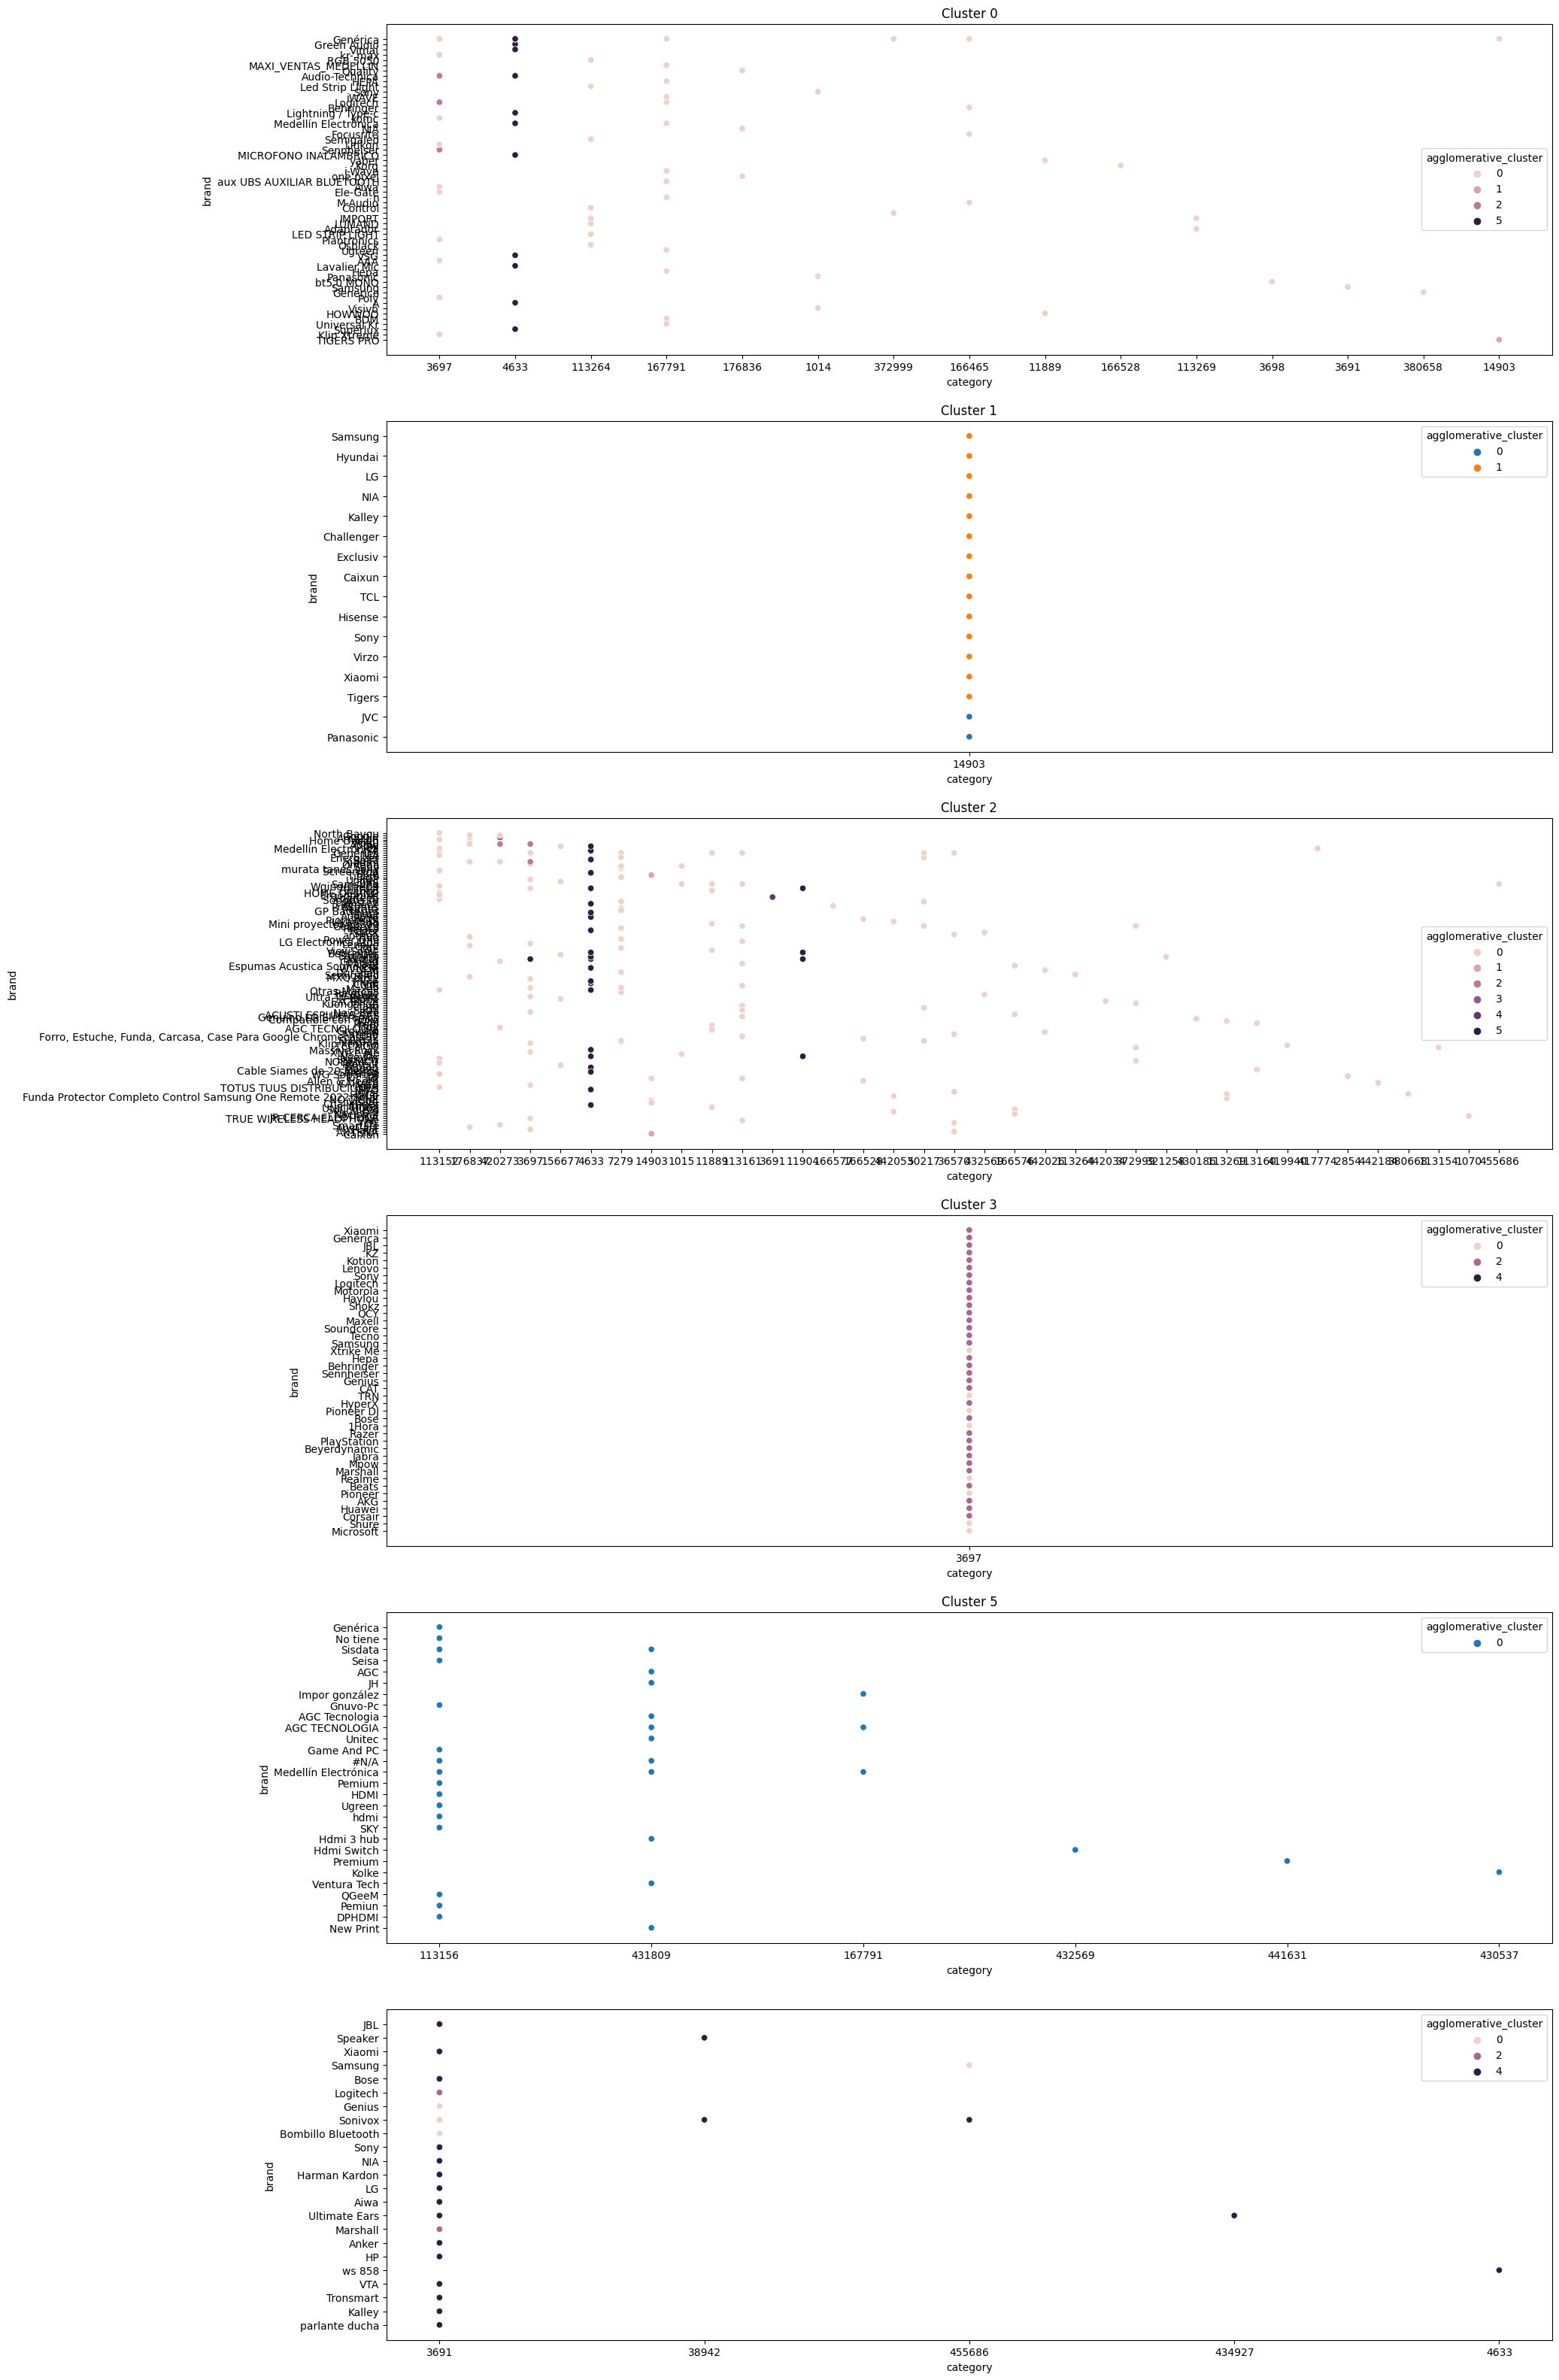

In [23]:
filtered_dict = {}

for i in range(6):
    filtered_dict[i] = filtered_items.loc[filtered_items['kmeans_cluster'] == i]
    
# Create a figure and subplots
fig, axs = plt.subplots(6, 1, figsize=(20, 40))

# Plot your data in each subplot using Seaborn
sns.scatterplot(data=filtered_dict[0], x='category', y='brand',hue='agglomerative_cluster', ax=axs[0])
axs[0].set_title('Cluster 0')

sns.scatterplot(data=filtered_dict[1], x='category', y='brand',hue='agglomerative_cluster', ax=axs[1])
axs[1].set_title('Cluster 1')

sns.scatterplot(data=filtered_dict[2], x='category', y='brand',hue='agglomerative_cluster', ax=axs[2])
axs[2].set_title('Cluster 2')

sns.scatterplot(data=filtered_dict[3], x='category', y='brand',hue='agglomerative_cluster', ax=axs[3])
axs[3].set_title('Cluster 3')

sns.scatterplot(data=filtered_dict[4], x='category', y='brand',hue='agglomerative_cluster', ax=axs[4])
axs[4].set_title('Cluster 4')

sns.scatterplot(data=filtered_dict[5], x='category', y='brand',hue='agglomerative_cluster', ax=axs[5])
axs[4].set_title('Cluster 5')



# Show the plot
plt.show()

In [17]:
filtered_dict[0]
    

,id,category_id,price,seller.seller_reputation.power_seller_status,brand,tokenized_title,category,kmeans_cluster,agglomerative_cluster
68,MCO1213237547,MCO3697,29999,platinum,Genérica,Audifonos Bluetoooth N65 Negro Fm Micro Sd Dia...,3697,0,0
133,MCO1271616419,MCO4633,13205,platinum,Green Audio,Micrófono Green Audio Lavalier Omnidireccional,4633,0,5
137,MCO1613328382,MCO4633,135000,gold,Vimai,Microfono Inalambrico Solapa Dual Usb Tipo C E...,4633,0,5
149,MCO1243875574,MCO3697,55400,platinum,kr- max,Diadema Inalámbrica Bluetooth Krmax Air Pods R...,3697,0,0
164,MCO614541425,MCO113264,48000,platinum,RGB 5050,Cinta Led Rgb Bluetooth Luces Usb Tv Hogar Mús...,113264,0,0
...,...,...,...,...,...,...,...,...,...
946,MCO1299358835,MCO4633,784900,platinum,Audio-Technica,Micrófono Audio-technica At2035 Condensador Ca...,4633,0,5
958,MCO872088581,MCO4633,68900,platinum,Medellín Electrónica,Microfono Condensador Omnidireccional Usb Comp...,4633,0,5
965,MCO614538056,MCO113264,30900,platinum,RGB 5050,Cinta Multicolor Led Luces Usb Rgb Luz 3 Metros,113264,0,0
977,MCO1002005060,MCO166465,1564457,silver,Focusrite,Interfaz Audio Focusrite Scarlett 4i4 3.ª Gen,166465,0,0


In [18]:
filtered_dict[1]

,id,category_id,price,seller.seller_reputation.power_seller_status,brand,tokenized_title,category,kmeans_cluster,agglomerative_cluster
1,MCO1137137999,MCO14903,2049980,platinum,Samsung,Televisor Samsung 55 Crystal Uhd 4k Bu8200 Sma...,14903,1,1
5,MCO1073618776,MCO14903,1899900,platinum,Samsung,Smart Tv Samsung Series 6 Qn50q60bakxzl Qled T...,14903,1,1
9,MCO1086389873,MCO14903,799900,platinum,Samsung,Smart Tv Samsung Series 4 Un32t4300akxzl Led T...,14903,1,1
15,MCO655996378,MCO14903,1118900,silver,Samsung,Smart Tv Samsung Series 5 Un40t5290akxzl Led T...,14903,1,1
19,MCO1250888726,MCO14903,1829800,platinum,Samsung,Televisor Samsung 50 Pulgadas Uhd 4k 50bu8200 ...,14903,1,1
...,...,...,...,...,...,...,...,...,...
978,MCO559309595,MCO14903,1149900,gold,Caixun,Televisor Caixun Ultrahd Cx43p28 43 Pulgadas T...,14903,1,1
984,MCO895413875,MCO14903,7699900,None,LG,Televisor LG 65 Oled 4k Uhd Smart Tv Webos Ole...,14903,1,1
988,MCO1010379268,MCO14903,1274900,platinum,Panasonic,Televisor Panasonic 42 Smart Tv,14903,1,0
998,MCO960356276,MCO14903,1769900,platinum,Hyundai,Televisor Hyundai Q Led 50 Pulgadas Smart 4k,14903,1,1


In [19]:
filtered_dict[2]

,id,category_id,price,seller.seller_reputation.power_seller_status,brand,tokenized_title,category,kmeans_cluster,agglomerative_cluster
3,MCO877866360,MCO113152,51299,platinum,North Bayou,Soporte North Bayou Nb-p4 Pared Tv/monitor 32 ...,113152,2,0
7,MCO1221261856,MCO176837,198000,gold,Google,Google Chromecast Hd,176837,2,0
10,MCO1168621277,MCO420273,175472,gold,Amazon,Amazon Echo Dot 3rd Gen Asistente Virtual Alex...,420273,2,3
12,MCO1640442118,MCO113152,32080,platinum,Home Design,Soporte Home Design Hdl-117b-2 Pared Tv/monito...,113152,2,0
13,MCO870314784,MCO176837,139900,platinum,Google,Google Chromecast Ga00439 3.ª Generación Full ...,176837,2,0
...,...,...,...,...,...,...,...,...,...
990,MCO821919519,MCO430186,33900,gold,Compatible con Roku,Control Remoto Mando Repuesto Roku 1/ 2/ 3/ 4 ...,430186,2,0
992,MCO563536162,MCO113161,17900,platinum,Genérica,Control Tv Samsung Smart Boton Netflix Amazon ...,113161,2,0
994,MCO1584848750,MCO14903,459900,None,Caixun,Televisor Monitor Caixun 24 Cx24t1,14903,2,1
995,MCO817209830,MCO4633,354900,platinum,Fifine,Micrófono Fifine K780 Condensador Cardioide Negro,4633,2,5


In [20]:
filtered_dict[3]

,id,category_id,price,seller.seller_reputation.power_seller_status,brand,tokenized_title,category,kmeans_cluster,agglomerative_cluster
0,MCO1341701368,MCO3697,114890,platinum,Xiaomi,Audífonos In-ear Gamer Inalámbricos Xiaomi Red...,3697,3,2
2,MCO1274347483,MCO3697,28539,gold,Genérica,Audífonos In-ear Inalámbricos F9-5 Negro,3697,3,2
4,MCO873828651,MCO3697,37000,platinum,JBL,Audífonos In-ear Jbl Tune 110 Jblt110 X 1 Unid...,3697,3,2
6,MCO858527853,MCO3697,53900,gold,KZ,Audífonos In-ear Kz Edx With Mic Negro,3697,3,2
8,MCO613166754,MCO3697,62200,platinum,Kotion,Audífonos Gamer Kotion G2000 Negro Azul Luz Led,3697,3,2
...,...,...,...,...,...,...,...,...,...
972,MCO1265623351,MCO3697,318045,None,Razer,Audífonos Gamer Razer Kraken X Classic Black L...,3697,3,2
979,MCO958526012,MCO3697,29900,platinum,Sony,Audífonos In-ear Sony Ex Series Mdr-ex15lp Rosa,3697,3,2
989,MCO1048893081,MCO3697,39105,gold,CAT,Audífonos Inalámbricos Cat Stn-28 Verde,3697,3,2
991,MCO1323870664,MCO3697,32919,silver,JBL,Audífonos In-ear Jbl C50hi Blanco,3697,3,2


In [21]:
filtered_dict[4]

,id,category_id,price,seller.seller_reputation.power_seller_status,brand,tokenized_title,category,kmeans_cluster,agglomerative_cluster
21,MCO1211306655,MCO113156,8298,platinum,Genérica,Cable Hdmi 5 Metros Doble Filtro Mallado Punta...,113156,4,0
129,MCO1245581311,MCO113156,21136,platinum,No tiene,Cable Hdmi 10 Metros Mallado . Doble Filtro Nú...,113156,4,0
158,MCO584762992,MCO113156,17850,platinum,Sisdata,Adaptador Convertidor Cable Hdmi Vga 1080p Bogotá,113156,4,0
187,MCO1615060534,MCO113156,49900,platinum,Seisa,Cable Hdtv Hdmi Macho Macho 20 Metros - Mallad...,113156,4,0
188,MCO593734391,MCO431809,13500,platinum,AGC,Cable Convertidor Hdmi Vga Pc Laptop Tv Monito...,431809,4,0
240,MCO1579948662,MCO431809,24653,platinum,JH,Convertidor Adaptador Display Port Macho Hdmi ...,431809,4,0
308,MCO1292320998,MCO167791,24626,platinum,Impor gonzález,Convertidor Hdmi ( dvd Ps4 Xbox ) Rca Av Telev...,167791,4,0
318,MCO1213341997,MCO113156,63000,gold,Gnuvo-Pc,Cable Hdmi 2.1 Gamer 8k 4k 2k 3 Metros 120 Hz ...,113156,4,0
324,MCO625421787,MCO431809,16900,platinum,AGC Tecnologia,Cable Convertidor Adaptador Displayport Hdmi P...,431809,4,0
333,MCO830395034,MCO167791,26900,platinum,AGC TECNOLOGIA,Convertidor Rca Hdmi Vhs Camara Play 2 Wii Xbo...,167791,4,0


In [22]:
filtered_dict[5]

,id,category_id,price,seller.seller_reputation.power_seller_status,brand,tokenized_title,category,kmeans_cluster,agglomerative_cluster
16,MCO1520233996,MCO3691,190000,platinum,JBL,Parlante Jbl Go 3 Portátil Bluetooth Waterproo...,3691,5,4
26,MCO1292205033,MCO3691,631115,None,JBL,Parlante Jbl Charge 5 Portátil Bluetooth Water...,3691,5,4
43,MCO966329690,MCO3691,470000,silver,JBL,Parlante Jbl Flip 6 Portátil Bluetooth Waterpr...,3691,5,4
57,MCO1285321337,MCO38942,52822,platinum,Speaker,Parlante Speaker B28s Portátil Bluetooth Negra,38942,5,4
70,MCO1193132247,MCO3691,194880,silver,Xiaomi,Parlante Xiaomi Portable Bluetooth Speaker ( 1...,3691,5,4
...,...,...,...,...,...,...,...,...,...
942,MCO1597708080,MCO3691,1053900,None,JBL,Parlante Jbl Partybox Encore Essential Portáti...,3691,5,4
952,MCO923959559,MCO3691,1418310,platinum,Bose,Parlante Bose Tv Speaker Bluetooth Negra 100v/...,3691,5,4
955,MCO941038862,MCO3691,648000,None,Tronsmart,Parlante Tronsmart Bang Portátil Bluetooth Wat...,3691,5,4
970,MCO1625062296,MCO3691,109900,None,Kalley,Parlante Kalley K-bsk8w Negro 8w Rms Bluetooth,3691,5,4
